## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources:
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`.
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference:

In [1]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [2]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip, geom_bar,scale_x_discrete, geom_point, theme,element_text, geom_boxplot, coord_cartesian, scale_color_manual

In [3]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [4]:
from google.colab import files
uploaded = files.upload()

Saving financials_against_return.feather to financials_against_return.feather


In [5]:
import os
os.listdir()

['.config', 'financials_against_return.feather', 'sample_data']

In [6]:
data_set = pd.read_feather("financials_against_return.feather")

Remove these quarters which have less than `minimum_number_of_tickers` tickers:

In [7]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [8]:
data_set.shape

(170483, 145)

Create the target:

In [9]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

,count
target,
0.0,82437
1.0,73829


This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [10]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [11]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]

    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')

    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [12]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_730",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]

    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [13]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set, n_estimators = 300):
    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")


    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}


    objective = 'binary'
    metric = 'binary_logloss'
    params = {
             "random_state":1,
             "verbosity": -1,
             "n_jobs":10,
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}

    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test





This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [14]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None

        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)

            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test


execution_dates = np.sort(data_set['execution_date'].unique())


This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [15]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": 'binary',
    "metric": 'binary_logloss',
    "n_estimators": 40
}

def train_model_across_periods(n_estimators):
    global all_results
    global all_predicted_tickers_list
    global all_models
    global all_predicted_tickers

    for execution_date in execution_dates:
        print(execution_date)
        all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(
            execution_date, all_results, all_predicted_tickers_list, all_models, n_estimators
        )

    all_predicted_tickers = pd.concat(all_predicted_tickers_list)

train_model_across_periods(n_estimators=params["n_estimators"])

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [16]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])

    df["execution_date"] = df["execution_date"].astype(str)

    return df

In [17]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [18]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


And these are the results:

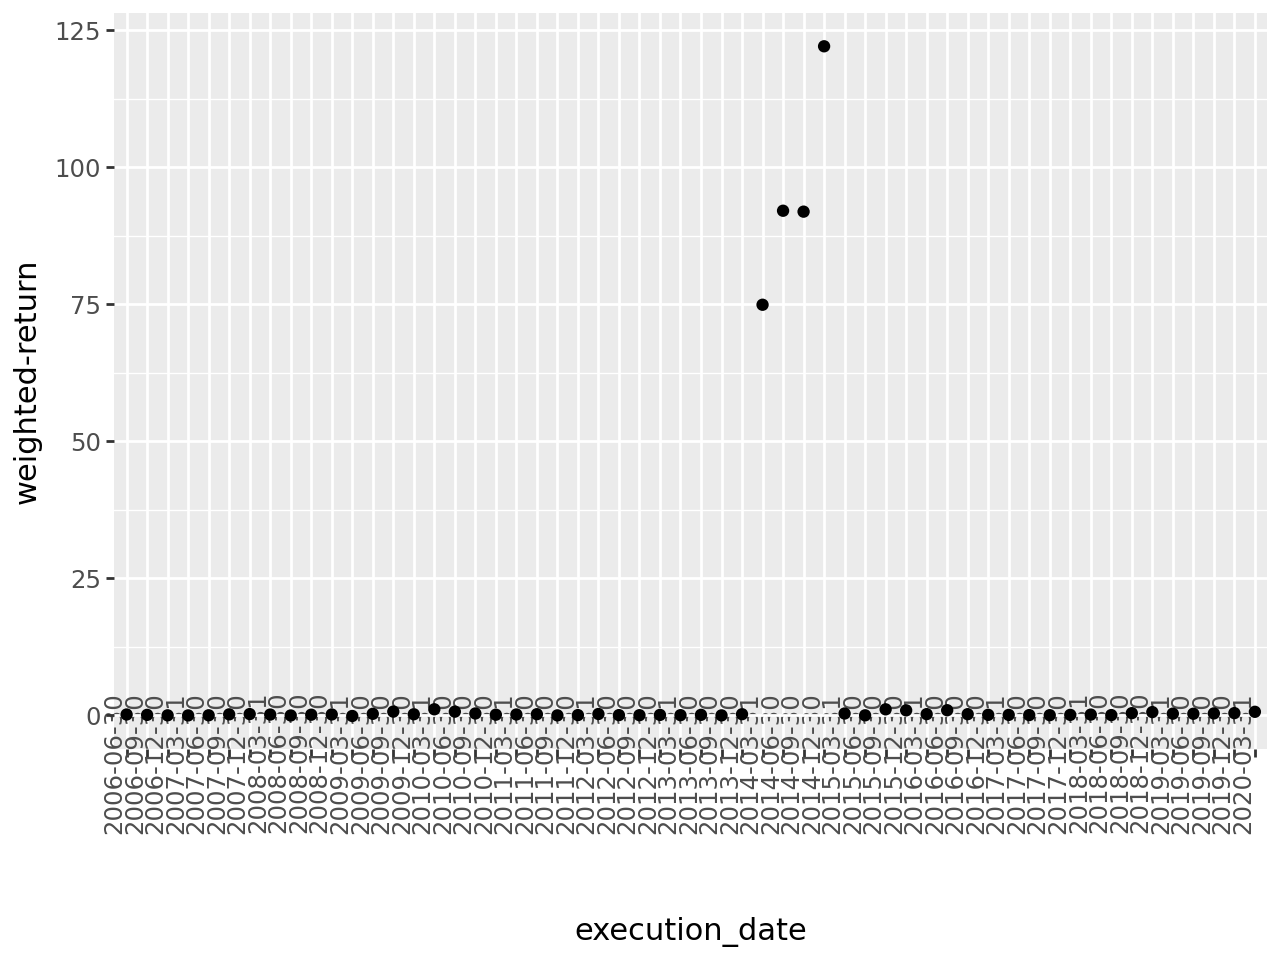

In [19]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

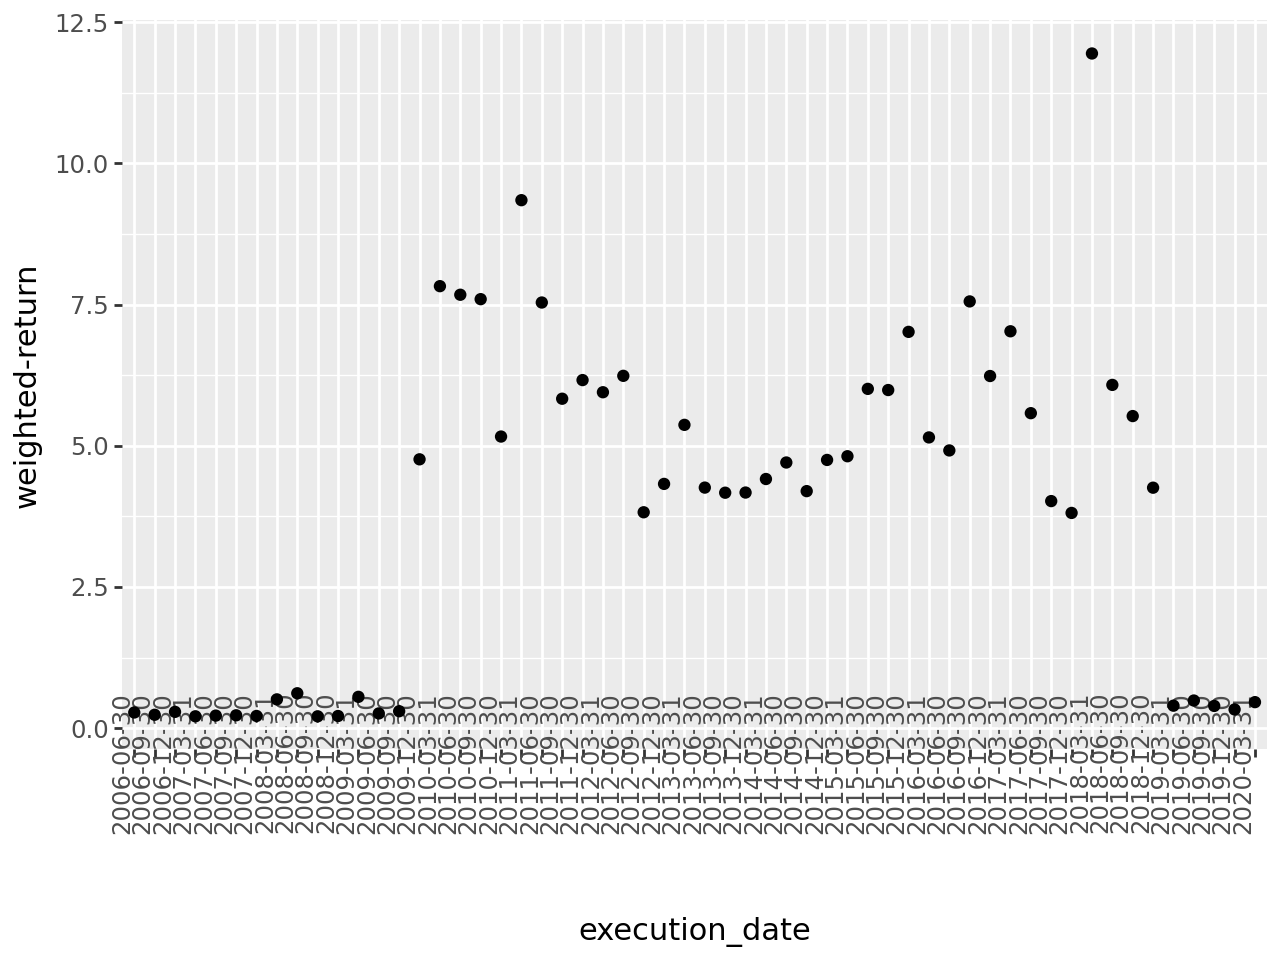

In [20]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [21]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


In [22]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# **Proposed solution**

## **Benchmark /dumb model:** Sp500 Equal Weight

In order to understand if our model is adding any value at all, let's create a simple benchmark to compare against: the average surplus over the sp500 of the 500 stocks
with more market cap:

In [23]:
def merge_against_benchmark(metrics_df, all_predicted_tickers, top_n_market_cap=500):
    all_predicted_tickers = all_predicted_tickers.sort_values(['execution_date', 'Market_cap'], ascending=[False, False])
    all_predicted_tickers["rank"] = all_predicted_tickers.groupby(['execution_date']).cumcount()
    all_predicted_tickers_top_mc = all_predicted_tickers[all_predicted_tickers["rank"] <= top_n_market_cap]
    baseline = all_predicted_tickers_top_mc.groupby("execution_date")["diff_ch_sp500"].mean().reset_index()
    baseline = baseline.rename(columns={"diff_ch_sp500": "diff_ch_sp500_baseline"})
    baseline["execution_date"] = baseline["execution_date"].astype(str)
    metrics_df = pd.merge(metrics_df, baseline, on="execution_date")
    return metrics_df

In [24]:
test_results_final_tree = merge_against_benchmark(test_results_final_tree, all_predicted_tickers)

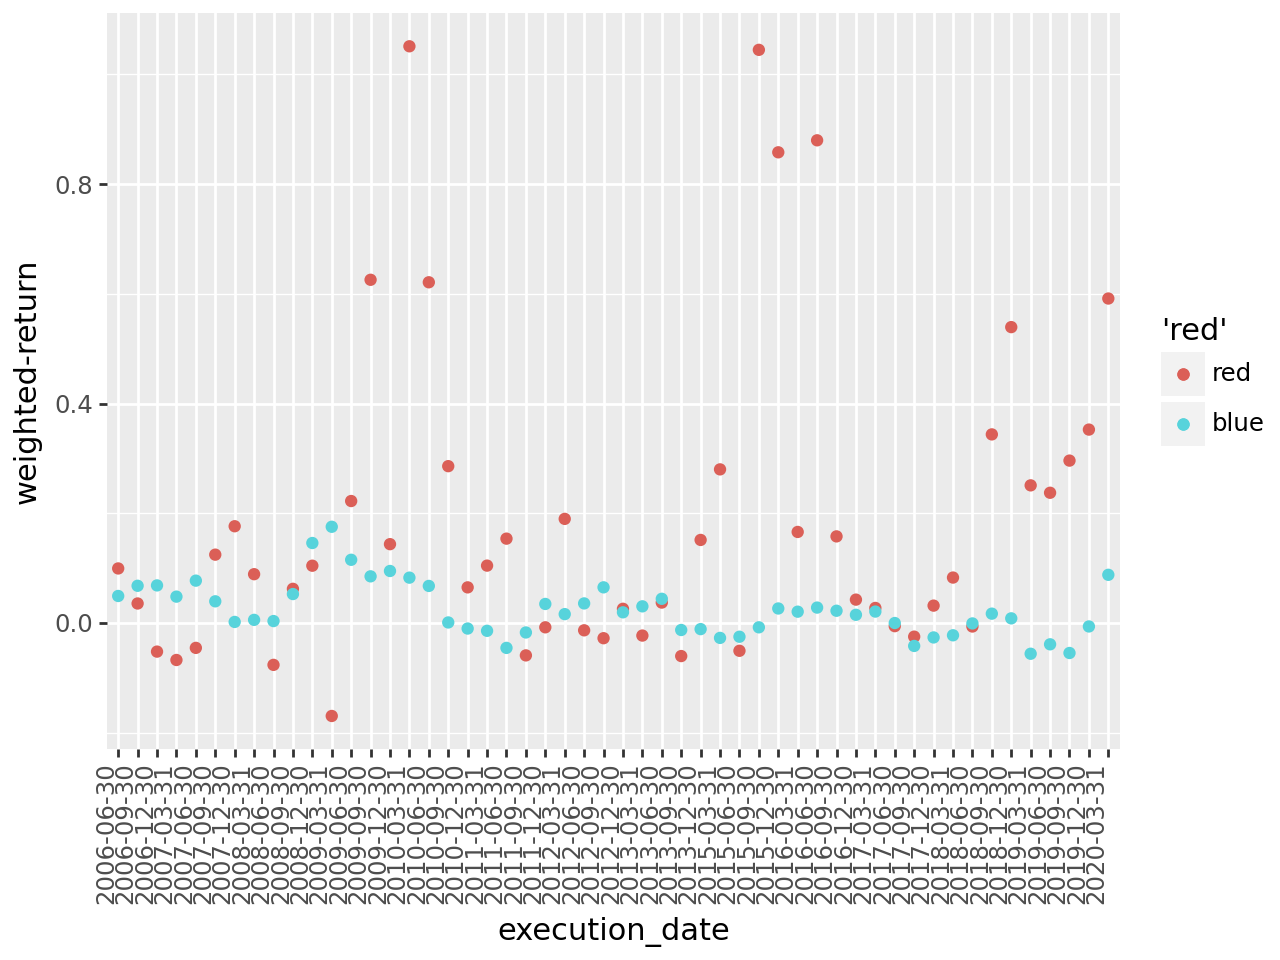

In [25]:
ggplot(test_results_final_tree[test_results_final_tree["weighted-return"] < 2], aes(x="execution_date")) + geom_point(aes(y="weighted-return", color="'red'")) + geom_point(aes(y="diff_ch_sp500_baseline", color="'blue'")) + theme(axis_text_x=element_text(angle=90, hjust=1))

The blue points are the benchmark, and the red points are my model

N periods where we perform better than benchmark:

In [26]:
len(test_results_final_tree[test_results_final_tree["weighted-return"] > test_results_final_tree["diff_ch_sp500_baseline"]]) / len(test_results_final_tree["diff_ch_sp500_baseline"])

0.6964285714285714

My model performs better than benchamrk in 69% of all periods

Median performance vs benchmark:

In [27]:
test_results_final_tree["weighted-return"].median()

0.11454718271321802

My model has a difference of 10% in the return of the following year (too high -> data leakage)

In [28]:
test_results_final_tree["diff_ch_sp500_baseline"].median()

0.015525563344158869

In [29]:
test_results_final_tree["weighted-return"].mean()

6.979676945548215

As there are periods with a very high performance, we calculate the mean. The mean is 400% of difference, which it's so so high.

In [30]:
test_results_final_tree["diff_ch_sp500_baseline"].mean()

0.022159133577893696

The difference between the Sp500 and the Benchmark (Sp500 Equal Weight) is minimum.

Before looking at feature importance, we have to see if the model is learning or not. This is because there is no sense in looking at features of a model that does not make any sense (Overfitting).

## **Is the model learning and generalizing?**

The first thing I normally do is to understand if the model is learning and generalizing at all or it's overfitting heavily. For that, I start by visualizing learning curves where I plot the evolution of different metrics in train and test over the different boosted trees.

Even if it's important to have the final business metric that we want to optimize in mind (the weighted return), that one is **not** the metric that the model is trying to optimize (which is binary_logloss). That's why, in order to understand what the model is doing and improve on it, **it's normally better to work with these metrics which are closer to the model, since the top-level metrics are gonna have more variance and are gonna be harder to act upon.**

In [31]:
def return_learning_curve(set_name):
    learning_curves = pd.DataFrame()
    for date in all_results:
        learning_curve = pd.DataFrame(all_results[date][set_name])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["execution_date"] = date
        learning_curves = pd.concat([learning_curves, learning_curve])

    for column in learning_curves.columns:
        if column not in ["n_trees", "execution_date"]:
            first_metric = learning_curves[[column, "execution_date"]].drop_duplicates(['execution_date'])
            first_metric = first_metric.rename(columns={column: "first_" + column})
            learning_curves = pd.merge(learning_curves, first_metric, on=["execution_date"])
            learning_curves["norm_" + column] = (learning_curves[column] - learning_curves["first_" + column]) / learning_curves["first_" + column]
            learning_curves = learning_curves.drop(columns="first_" + column)
    learning_curves["execution_date"] = learning_curves["execution_date"].astype(str)

    return learning_curves

The function above computes the % difference of each metric in each new tree with respect to the value of that metric in the first tree. This way we can see if the metric is improving or decreasing across trees.

In [32]:
test_lc = return_learning_curve("valid_0")
train_lc = return_learning_curve("training")

In [33]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

The model is clearly learning in training:

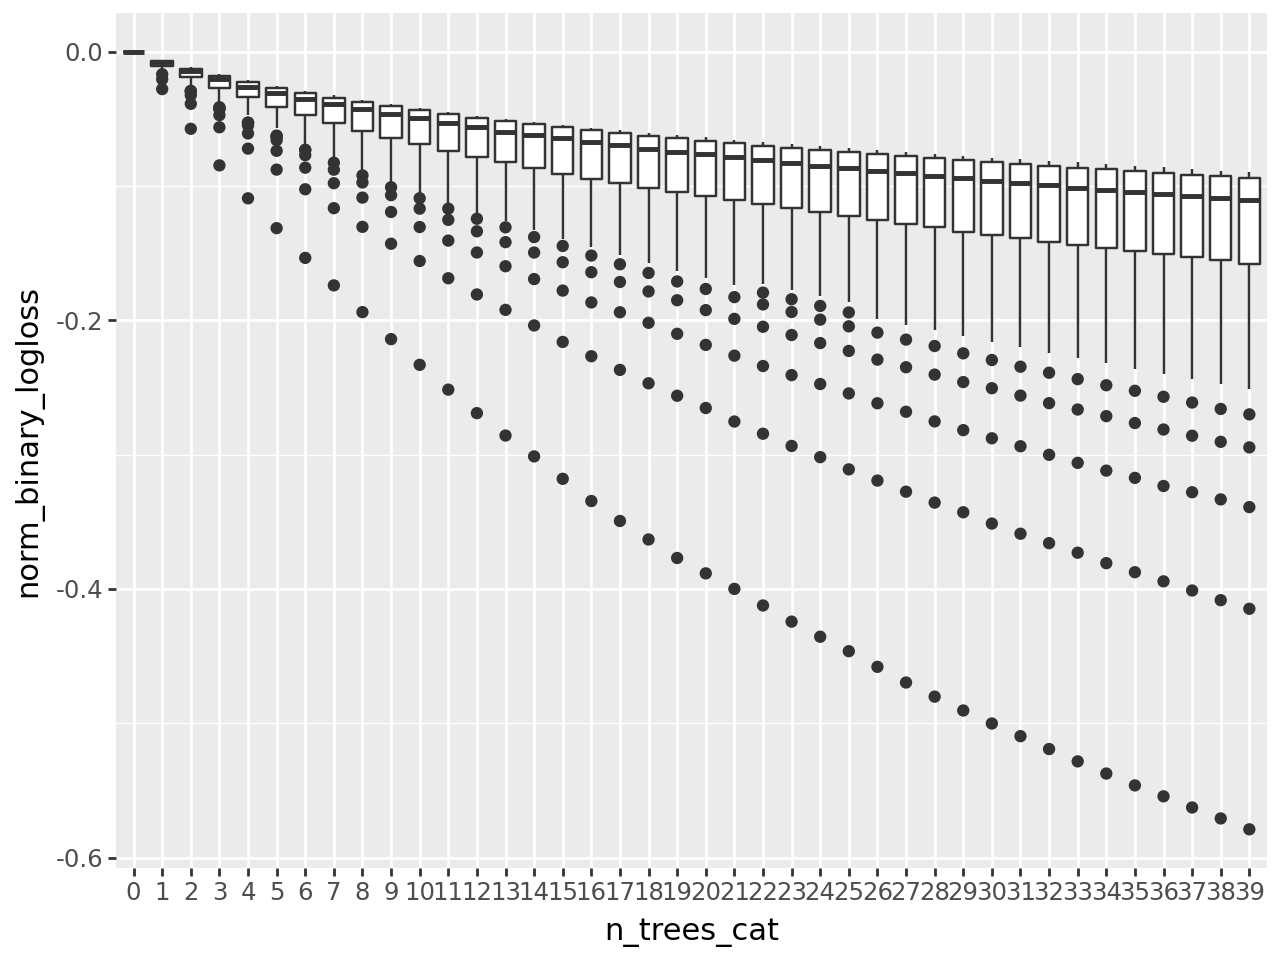

In [34]:
ggplot(train_lc, aes(x="n_trees_cat", y="norm_binary_logloss")) + geom_boxplot()

But it is harder to know in test due to outliers and the number of boosted trees

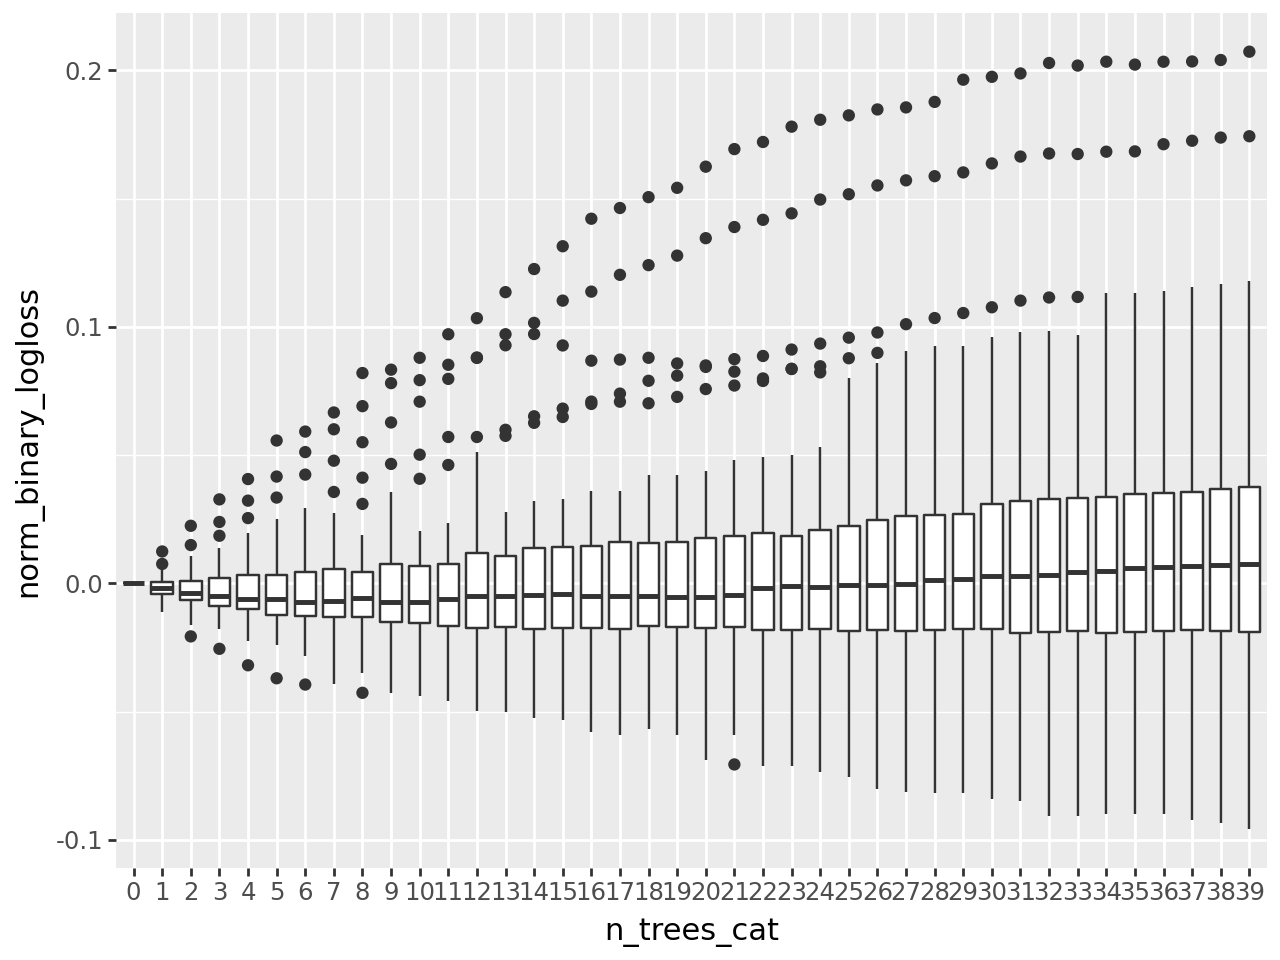

In [35]:
ggplot(test_lc, aes(x="n_trees_cat", y="norm_binary_logloss")) + geom_boxplot()

The median error is close to 0, so it is not good. There are outliers at the top that worsen the error.

Let's just consider the boxplot in the intervals [-0.025, 0.03] and just the first 20 trees. Even if we have periods where the norm binary log loss worsens with more trees, the median until the 20th tree seems to improve. Also, we see that it reaches its minimum around the 10th tree, so probably that is where we need to early stop. Additionally, it seems that the model will benefit from overfitting, so let's try to tune the model parameters a little bit to account for that.

Now we are looking only the first 20 trees because it seem to be the best part. Besides, we remove outliers.

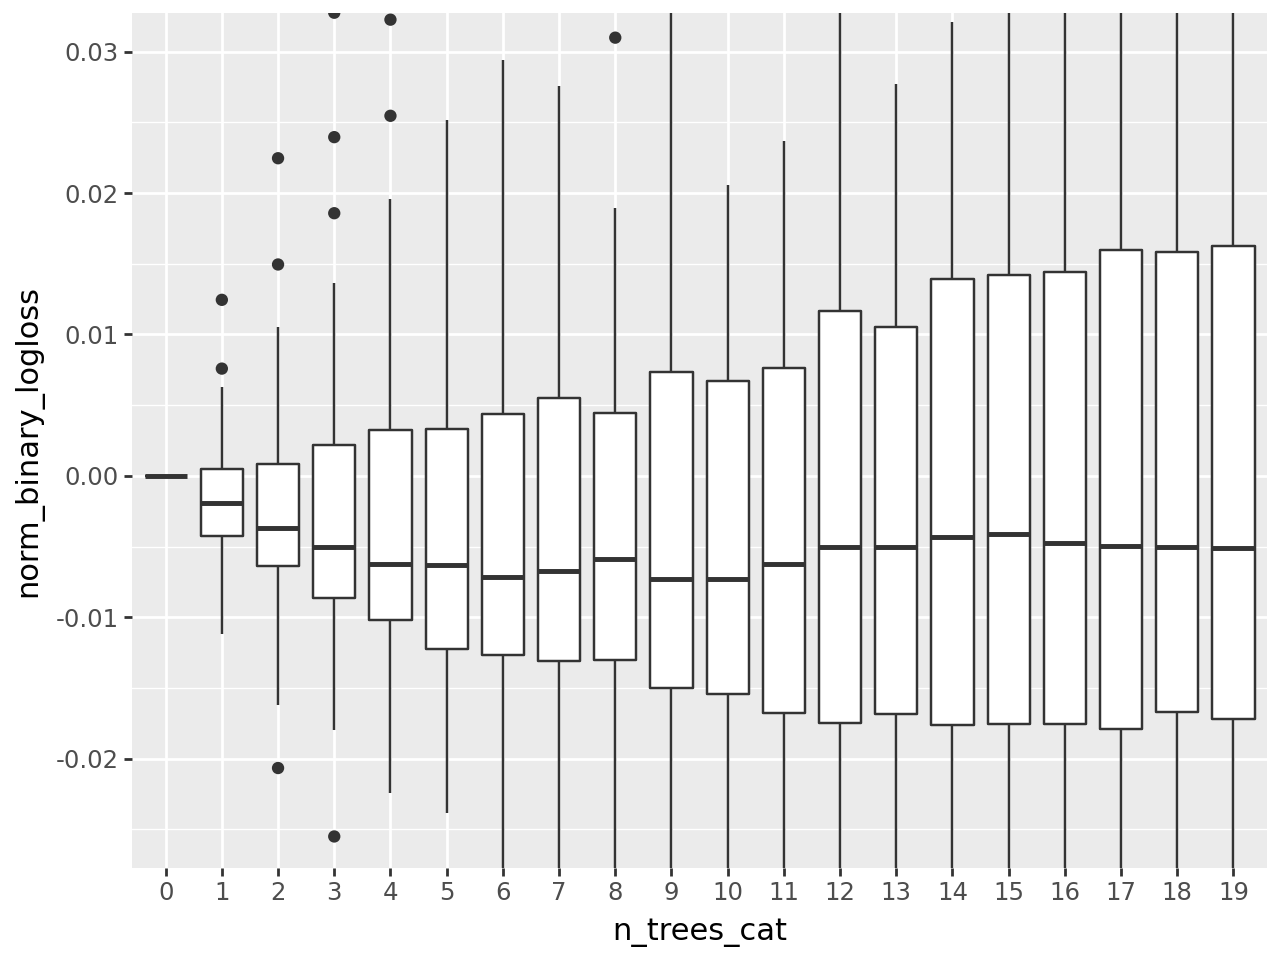

In [36]:
ggplot(test_lc[test_lc["n_trees"] < 20], aes(x="n_trees_cat", y="norm_binary_logloss")) + geom_boxplot(outlier_alpha=None) + coord_cartesian(ylim=[-0.025, 0.03])

Now we can see the median decreasing a bit, and then it increases. Overall, train and test come from a different distribution, and there is overfitting, Which is typical of this type of problem. Because of this, we have to try to simplify our model until it generalises, and to play with model parameters. Once we made it simple, then we can add complexity little by little.

In this problem we don't have a lot of data, so we have to be careful and not do manual overfitting by only changing the parameters. So we are going to try to change them only a bit, because of a business reason.

In particular, we change:

- **Learning rate**: One of the most important parameters, it controls how much we are going to weight each new tree compared to the previous ones.
- **N estimators**: The number of total trees we are going to fit.
- **Path smooth**: Controls smoothing applied to tree nodes.
- **Num leaves**: Self-explanatory.

Always start with small learning rates, which are going to give you more control over the variance of the model.

In [37]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": 'binary',
    "metric": 'binary_logloss',
    "learning_rate": 10e-3,
    "path_smooth": 0.2,
    "n_estimators": 20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}

train_model_across_periods(n_estimators=params["n_estimators"])

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [38]:
def create_and_combine_lc():
    test_lc = return_learning_curve("valid_0")
    train_lc = return_learning_curve("training")

    train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
    test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

    train_lc["set"] = "train"
    test_lc["set"] = "test"

    data_lc = pd.concat([train_lc, test_lc])
    return data_lc

In [39]:
data_lc = create_and_combine_lc()

Cool! This looks much better now: the test median keeps decreasing smoothly until the 20th tree. Also, observe that before, the 75th percentile was on the order of 0.01-0.02 positive, while now it is almost always close to 0. This means that for 75% of the periods, we are learning something as we train more trees. Additionally, note that the train loss decreases better than the test loss; in an ideal world, both would decrease at the same rate, but keep in mind that the distribution of train and test is different, so it will be impossible to completely eliminate certain overfitting.

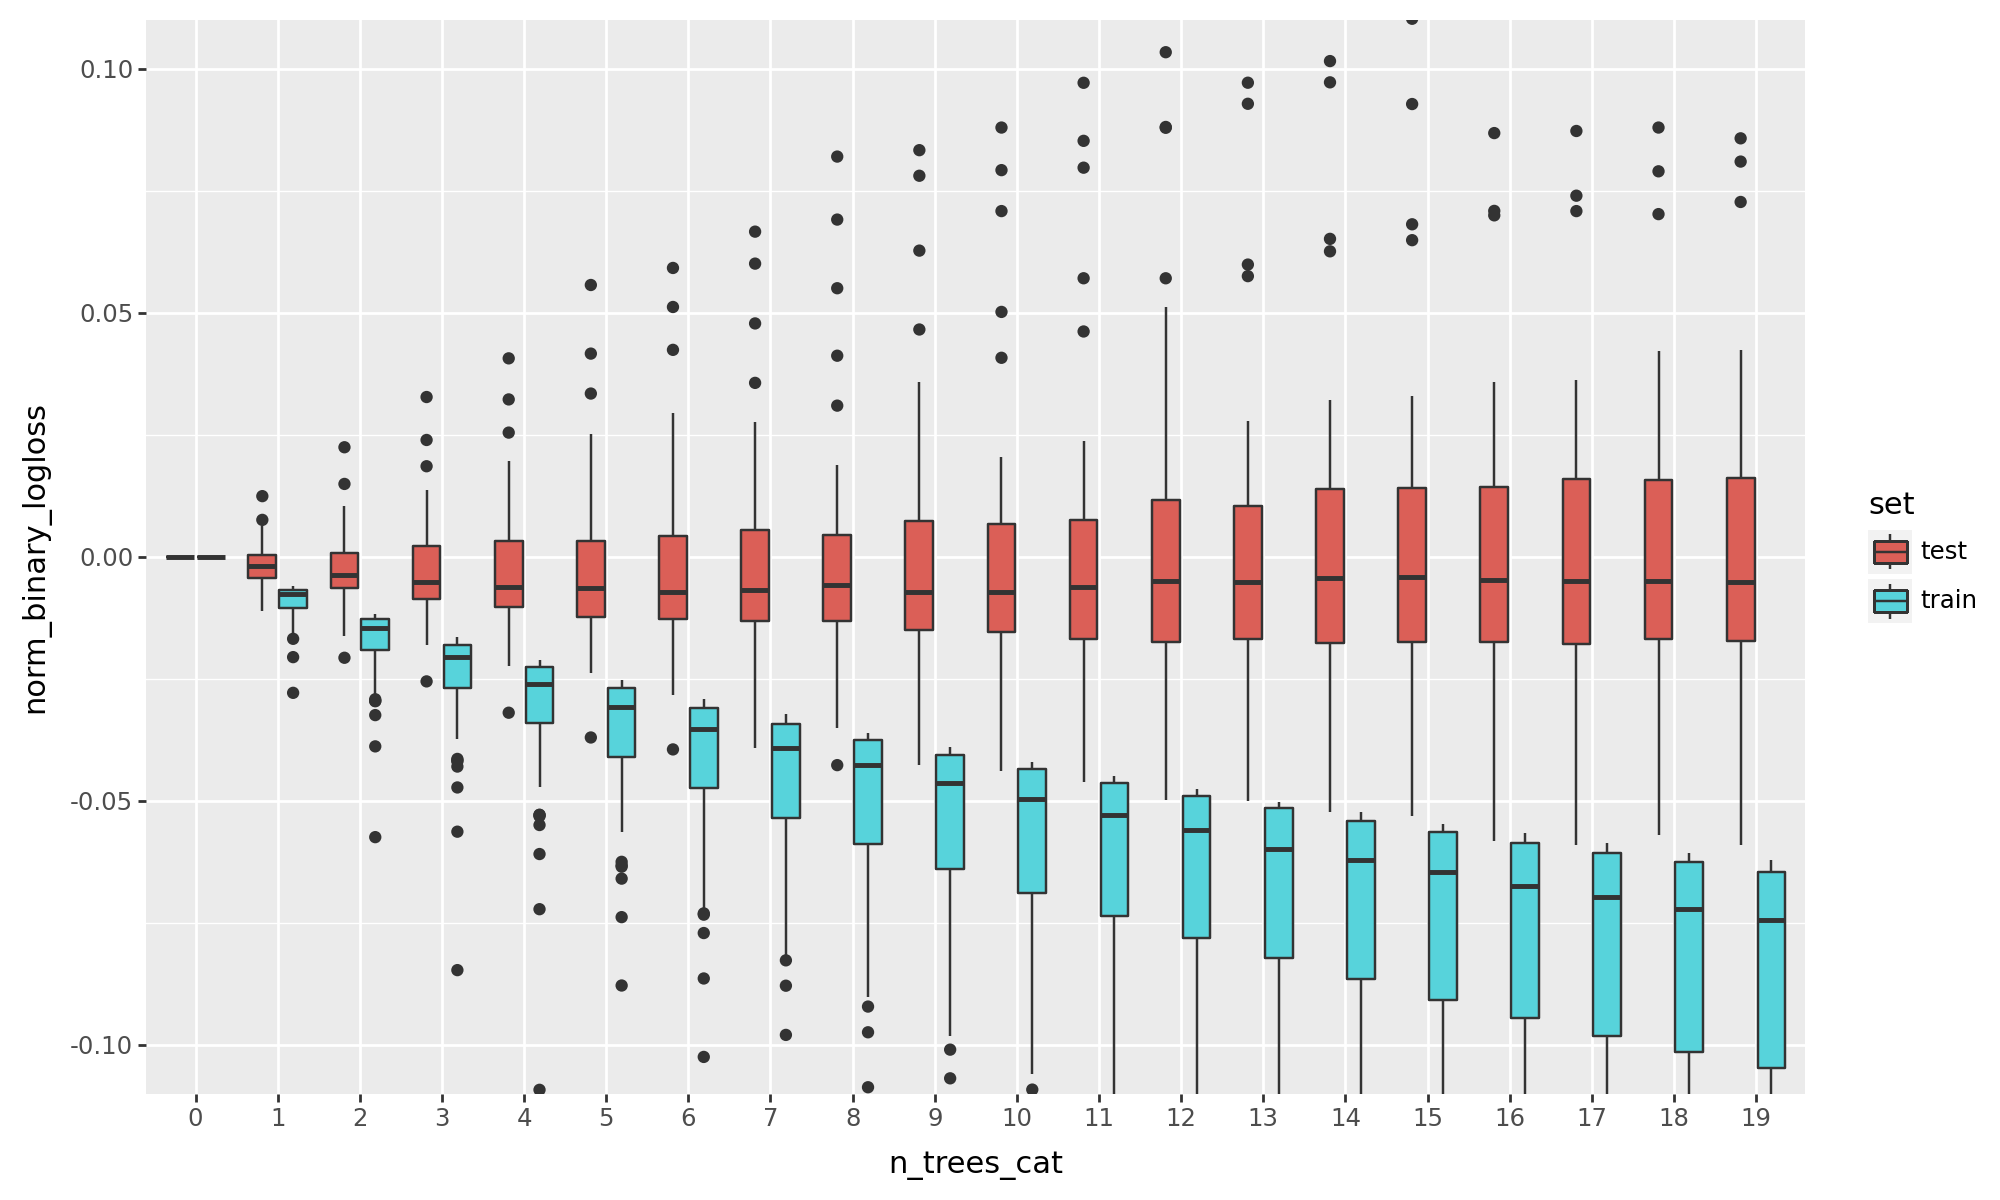

<Figure size 1000x600 with 0 Axes>

In [60]:
fig = plt.figure(figsize=(10, 6))

ggplot(
    data_lc[data_lc["n_trees"] < 20],
    aes(x="n_trees_cat", y="norm_binary_logloss", fill="set")
) + geom_boxplot(outlier_alpha=None) + coord_cartesian(ylim=(-0.1, 0.1)) + theme(
    figure_size=(10, 6)
)

Now we can see that we make much less overfitting as train and test errors are decreasing, and the difference is smaller. Also, it is decreasing all the time we add trees, so it is smooth. Q3 percentile is now close to 0, so at least it doesn't worsen.

### What is the feature importance? Do we have any kind of leaking?

Now let’s inspect the feature importance and try to understand if that makes sense. That method is implemented in `sklearn`. Fortunately, the LightGBM model has an `sklearn` API. We just need to adapt the call to use that API:

**Very important:** If we start using the `sklearn` API, we need to use `predict_proba` instead of `predict` to get the probabilities. We can monkey patch it:

In [41]:
from sklearn.inspection import permutation_importance
import sklearn

def train_model(train_set, test_set, compute_importance=False):
    global params
    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    model = lgb.LGBMClassifier(**params)
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

    eval_result = {}
    model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)],
              eval_metric=top_wt_performance, callbacks=[lgb.record_evaluation(eval_result)])

    if compute_importance:
        r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
        feature_names = X_test.columns
        df_permutation_importance = pd.DataFrame({'importance': r.importances_mean, 'feature': feature_names})
    else:
        df_permutation_importance = pd.DataFrame()

    return model, eval_result, X_train, X_test, df_permutation_importance

In [42]:
def run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, include_nulls_in_test=False, compute_importance=False):
    global train_set
    global test_set
    global all_permutation_importances

    # Split the dataset between train and test
    train_set, test_set = split_train_test_by_period(data_set, execution_date, include_nulls_in_test=include_nulls_in_test)
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = None
    X_test = None

    # If both train and test are not empty
    if train_size > 0 and test_size > 0:
        model, evals_result, X_train, X_test, df_permutation_importance = train_model(train_set, test_set, compute_importance)

        if isinstance(model, lgb.sklearn.LGBMClassifier):
            model = model.booster_

        test_set['prob'] = model.predict(X_test)
        predicted_tickers = test_set.sort_values('prob', ascending=False)
        predicted_tickers["execution_date"] = execution_date

        all_results[execution_date] = evals_result
        all_models[execution_date] = model
        all_predicted_tickers_list.append(predicted_tickers)

        df_permutation_importance["execution_date"] = execution_date
        all_permutation_importances = pd.concat([all_permutation_importances, df_permutation_importance])

    return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test

Also, the permutation importance calculation is a little bit slower. It doesn't make sense to compute it in any period, and that's why we modify the function train_model_across_periods to allow training in just a subset.

In [43]:
def train_model_across_periods(train_period_frequency=1, compute_importance=False):
    global all_results
    global all_predicted_tickers_list
    global all_models
    global all_predicted_tickers

    for i, execution_date in enumerate(execution_dates):
        if i % train_period_frequency == 0:
            print(execution_date)
            all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(
                execution_date, all_results, all_predicted_tickers_list, all_models, compute_importance=compute_importance
            )

    all_predicted_tickers = pd.concat(all_predicted_tickers_list)
    return all_results, all_predicted_tickers, all_models

In [61]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": 'binary',
    "metric": 'binary_logloss',
    "learning_rate": 10e-3,
    "path_smooth": 0.2,
    "n_estimators": 20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_across_periods(train_period_frequency=4, compute_importance=True)

2005-06-30T00:00:00.000000000
2006-06-30T00:00:00.000000000
2007-06-30T00:00:00.000000000
2008-06-30T00:00:00.000000000
2009-06-30T00:00:00.000000000
2010-06-30T00:00:00.000000000
2011-06-30T00:00:00.000000000
2012-06-30T00:00:00.000000000
2013-06-30T00:00:00.000000000
2014-06-30T00:00:00.000000000
2015-06-30T00:00:00.000000000
2016-06-30T00:00:00.000000000
2017-06-30T00:00:00.000000000
2018-06-30T00:00:00.000000000
2019-06-30T00:00:00.000000000
2020-06-30T00:00:00.000000000


({numpy.datetime64('2006-06-30T00:00:00.000000000'): {'training': OrderedDict([('binary_logloss',
                 [0.6763836854091063,
                  0.6742123838053882,
                  0.6721256566891489,
                  0.6700085327091294,
                  0.6678616750910891,
                  0.6657986859483864,
                  0.6637794927189853,
                  0.6617388667460092,
                  0.6597508272710894,
                  0.6577677703053585,
                  0.6557293575106298,
                  0.653813631477479,
                  0.6519254685189145,
                  0.649966035628589,
                  0.6479983787430886,
                  0.6461169370664551,
                  0.64430762654467,
                  0.6425167069562581,
                  0.6406078364074687,
                  0.6387532225533656]),
                ('weighted-return',
                 [0.27591729266499027,
                  0.27591729266499027,
                  0.2759172926

For each period, filter the top 5 most important features:

In [62]:
all_permutation_importances = all_permutation_importances.sort_values(["execution_date", "importance"], ascending=[False, False])

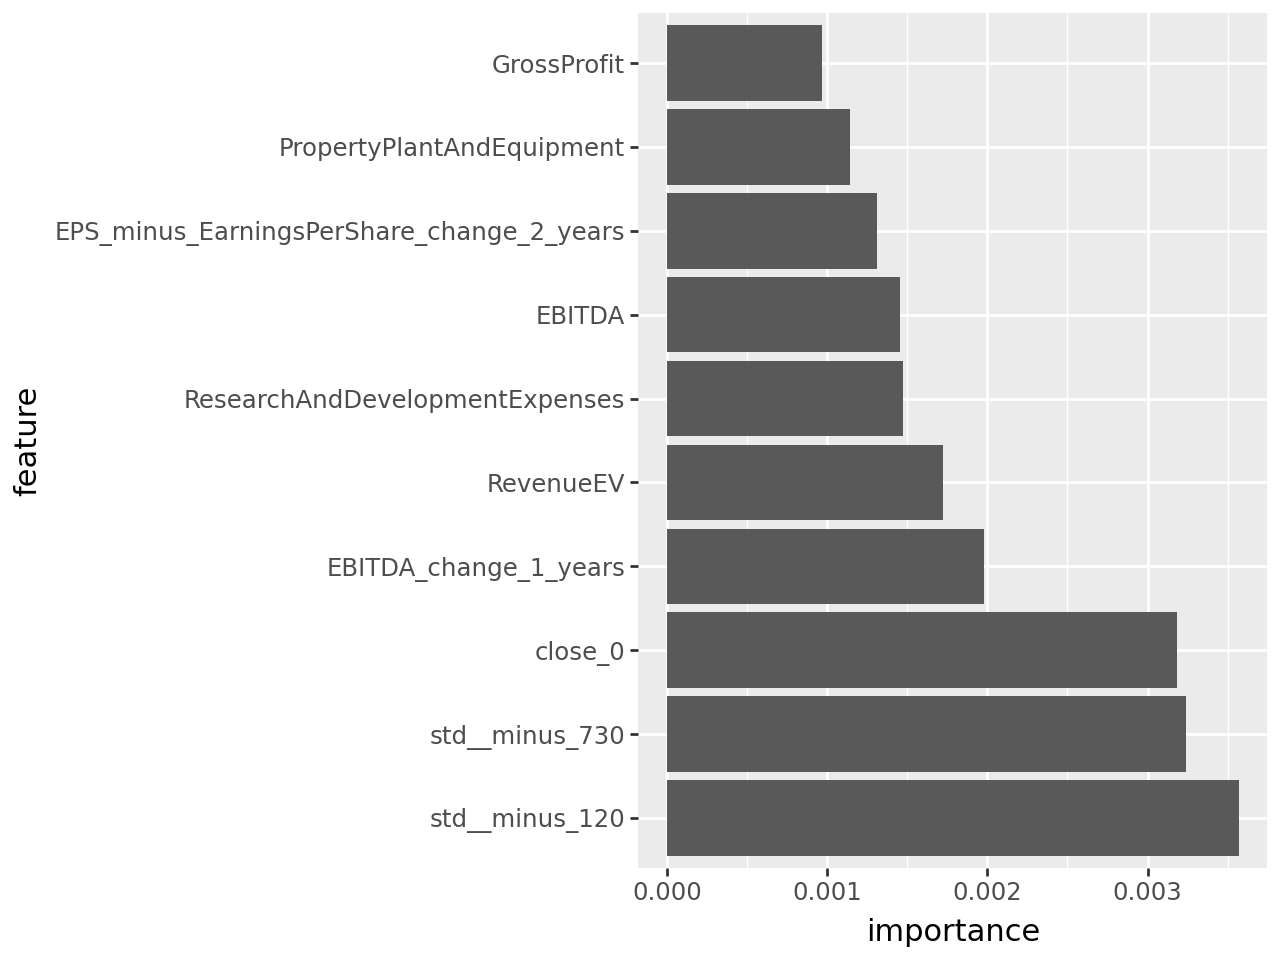

In [63]:
all_permutation_importances_sum = all_permutation_importances.groupby("feature")["importance"].mean().reset_index()

all_permutation_importances_sum = all_permutation_importances_sum.sort_values("importance", ascending=False)
all_permutation_importances_sum = all_permutation_importances_sum.head(10)

(
    ggplot(all_permutation_importances_sum) +
    geom_col(aes(x="feature", y="importance")) +
    coord_flip() +
    scale_x_discrete(limits=all_permutation_importances_sum["feature"].tolist())
)

This shows the average of the feature importance in all periods. It is a little bit suspicious that close_0 (the price of the stock at the moment of the prediction) is the most important feature overall. Let's try to see the feature importance across different periods:

In [64]:
all_permutation_importances["rank"] = all_permutation_importances.groupby(['execution_date']).cumcount()

r_all_permutation_importances = all_permutation_importances[all_permutation_importances["rank"] < 2]

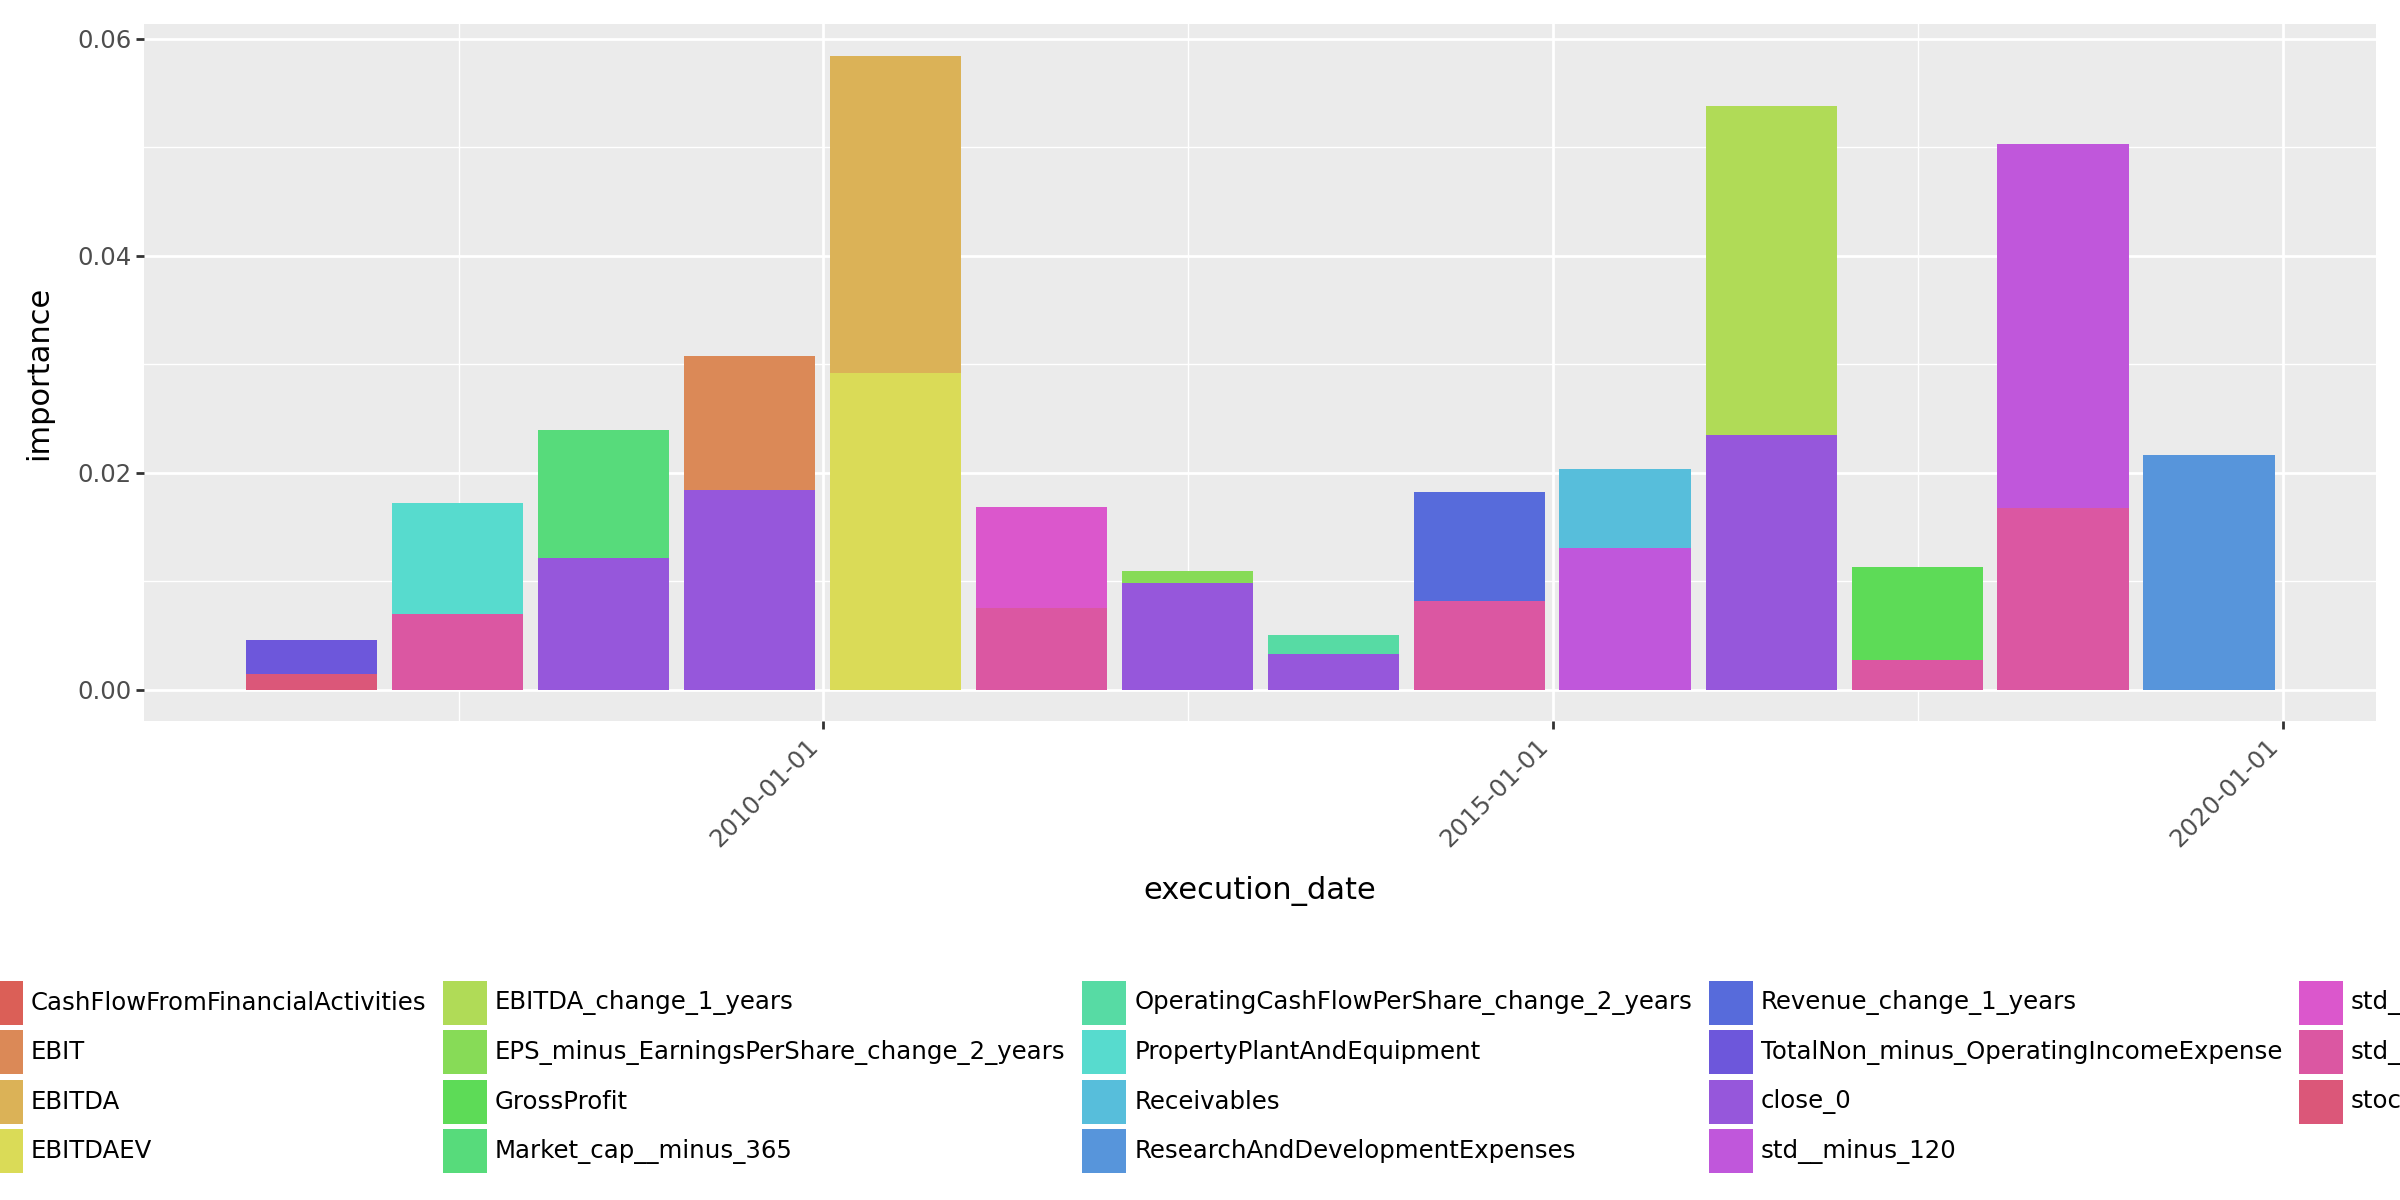

In [69]:
(
    ggplot(r_all_permutation_importances, aes(x="execution_date", y="importance", fill="feature")) +
    geom_col() +
    theme(
        figure_size=(12, 6),  # Ajusta el tamaño del gráfico
        axis_text_x=element_text(angle=45, hjust=1),  # Rota etiquetas del eje X
        legend_position="bottom"  # Mueve la leyenda abajo
    )
)

`close_0` is not always the most important feature, but in the periods where it is, it's very important. One option we could have chosen it's just deleting it. However, first we are going to try to understand why it is so important. Let's take, for example, **2009-06-30**.

In [70]:
all_permutation_importances[all_permutation_importances["execution_date"] == "2009-06-30"]

,importance,feature,execution_date,rank
87,0.018389,close_0,2009-06-30,0
17,0.012394,EBIT,2009-06-30,1
105,0.006383,EBITEV,2009-06-30,2
98,0.004385,std__minus_120,2009-06-30,3
116,0.003281,EPS_minus_EarningsPerShare_change_2_years,2009-06-30,4
...,...,...,...,...
122,-0.006831,EBITDA_change_2_years,2009-06-30,128
113,-0.007442,ROC,2009-06-30,129
69,-0.008934,RetainedEarningsAccumulatedDeficit,2009-06-30,130
19,-0.010887,EBITDA,2009-06-30,131


By seeing a period in which close_0 is very important, we can see the tickers with most and less probability for the model in order to see the differences.

These are the tickers with higher probability.

In [71]:
tickers = all_predicted_tickers[all_predicted_tickers["execution_date"] == "2009-06-30"].sort_values("prob", ascending=False)
tickers[["Ticker", "close_0", "prob"]].head(10)

,Ticker,close_0,prob
34343,PNC,38.810000,0.527120
33980,CM,50.208809,0.527120
36064,TM,75.530000,0.526818
35500,GS,147.440000,0.525329
34183,MBI,4.330000,0.524725
35930,EGY,4.230000,0.524725
35901,ROL,3.419259,0.524725
35957,INFY,4.597500,0.524725
35542,EW,5.669167,0.524725
34472,AAPL,5.086786,0.524725


These are the tickers with lower probability:

In [72]:
tickers = all_predicted_tickers[all_predicted_tickers["execution_date"] == "2009-06-30"].sort_values("prob", ascending=True)
tickers[["Ticker", "close_0", "prob"]].head(10)

,Ticker,close_0,prob
35083,CYCC,1900.080000,0.453509
35952,VBFC,75.200000,0.453509
35096,USEG,120.000000,0.453509
35909,TOWN,13.592233,0.454130
34237,PNFP,13.320000,0.454760
36056,SEED,46.400000,0.456984
33961,OPTT,1168.000000,0.456984
35706,MA,16.731000,0.457387
35747,TT,12.941984,0.458346
34760,ARNA,49.900000,0.458412


Let's try to understand both.

In [73]:
import shap

def get_shap_values_for_ticker_execution_date(execution_date, ticker=None):
    date = np.datetime64(execution_date)
    model_ = all_models[date]
    fn = model_.feature_name()

    X_test = all_predicted_tickers[(all_predicted_tickers["execution_date"] == date)]
    if ticker is not None:
        X_test = X_test[X_test["Ticker"] == ticker]

    X_test["Ticker"] = X_test["Ticker"].astype("category")
    X_test = X_test.sort_values("Ticker")

    if ticker is not None:
        explainer = shap.Explainer(model_)
        shap_values = explainer(X_test[fn])
        shap_values = shap_values[0]
    else:
        explainer = shap.Explainer(model_, X_test[fn])
        shap_values = explainer(X_test[fn])

    return shap_values

With SHAP close_0 shows also many importance.

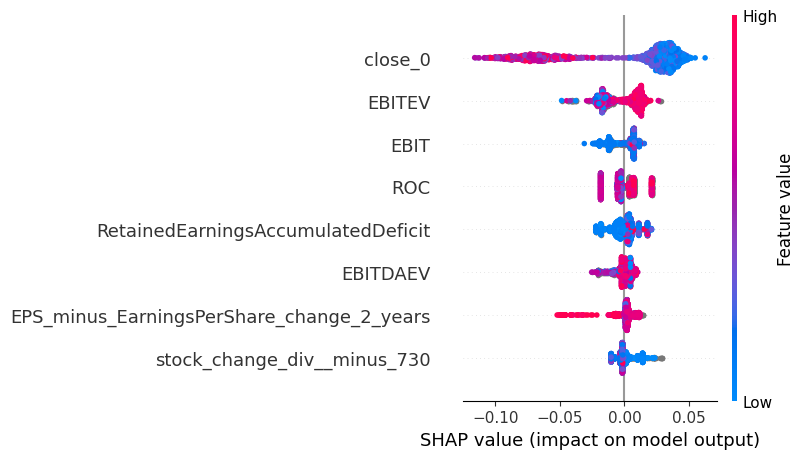

In [74]:
sv = get_shap_values_for_ticker_execution_date('2009-06-30T00:00:00.000000000')
shap.summary_plot(sv, max_display=8)

What we can see is that those stocks with a low price, our model is giving them a lot of probability. Stocks with a high price, our moder model is giving them little probability.

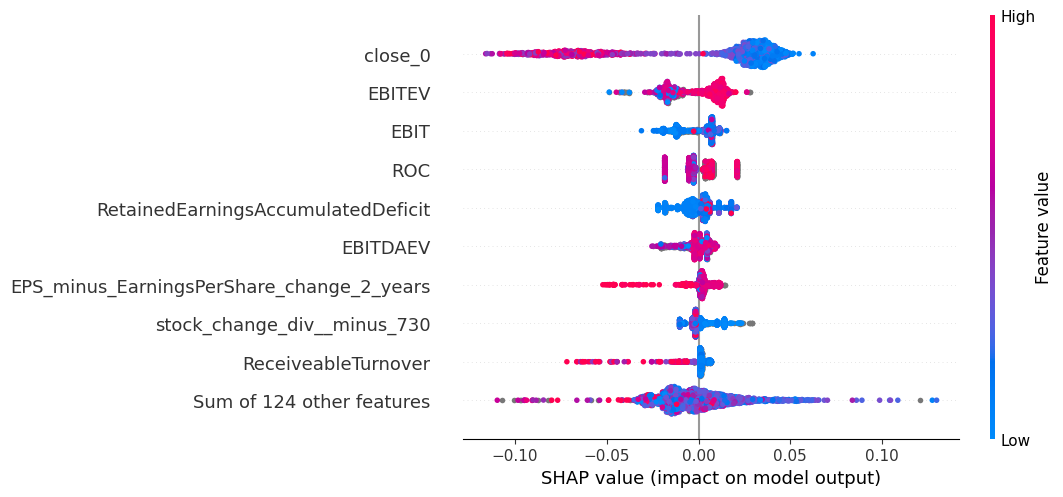

In [75]:
shap.plots.beeswarm(sv)

Stock price is an ordinary attribute which can be changed by doing splits or counter splits.

We are plotting the feature importance of some stocks with a high price and low probability of our model.

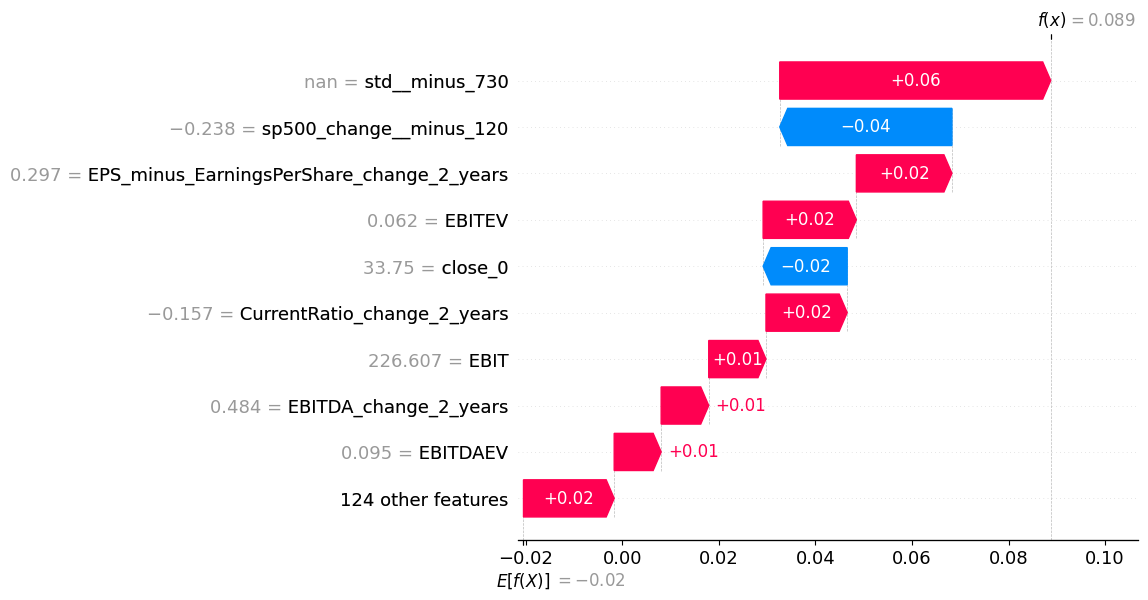

In [76]:
sv = get_shap_values_for_ticker_execution_date('2009-06-30T00:00:00.000000000', ticker="JW.B")
shap.plots.waterfall(sv)

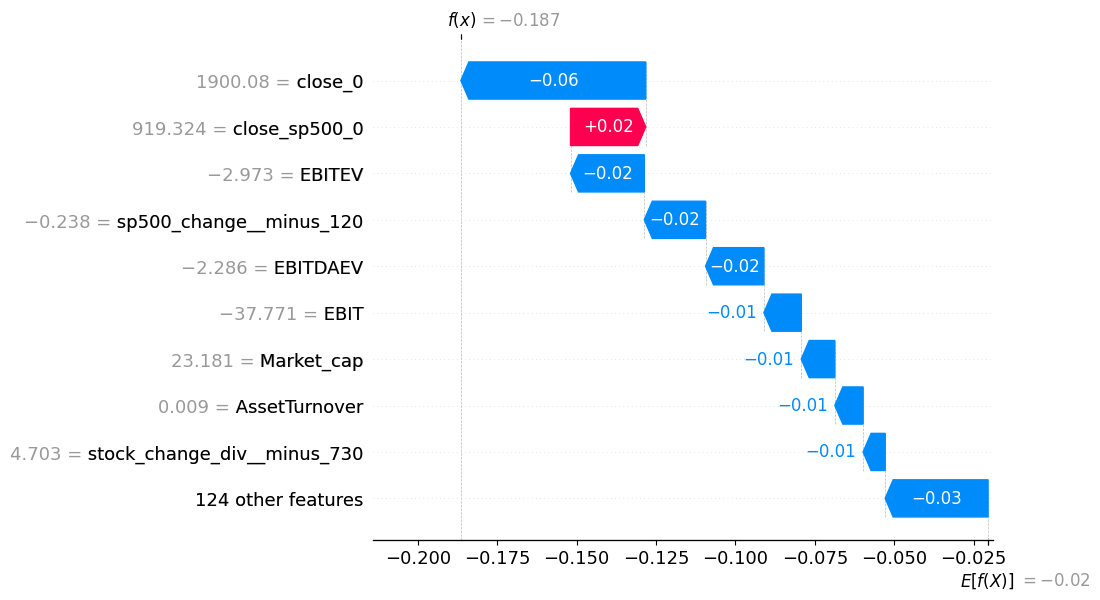

In [77]:
sv = get_shap_values_for_ticker_execution_date('2009-06-30T00:00:00.000000000', ticker="CYCC")
shap.plots.waterfall(sv)

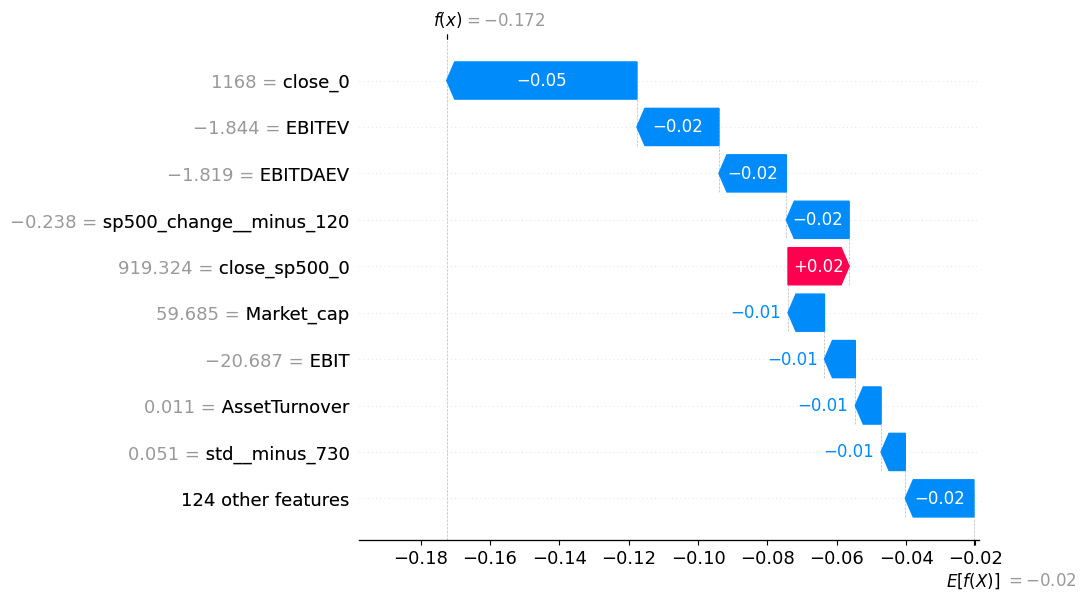

In [78]:
sv = get_shap_values_for_ticker_execution_date('2009-06-30T00:00:00.000000000', ticker="OPTT")
shap.plots.waterfall(sv)

### The CYCC Case:

- **The price when the model was supposed to be run:** 1900.08
- **Historical prices issue:** If we look into the historical prices ([Google Search](https://www.google.com/search?q=CYCC)), we see that the price in 2004 was **150,000 dollars!** This is too big and possibly something is wrong.
- **Reverse split explanation:**
  - When the price of a stock is too low, the number of stocks is divided by a multiplier, and the new price is computed accordingly.
  - For example, if we have 10 stocks at a 1-dollar price, a 2x reverse split will transform them into 5 stocks at a 2-dollar price each. This is just an accounting trick.
- **Historical stock price issue:**
  - The historical stock price that we have **TODAY** (in our dataset) is computed after the reverse splits, retrospectively.
  - This means that we are multiplying the original price by the reverse-split factors that have been applied over time. This is why the price is so big.
- **Model behavior:**
  - The model is learning that a high price → a reverse split is going to happen in the future → the reverse split will happen because the price is going to be too low → give low probability.
  - **This is data leakage!**

### Solution:
In order to play safely, **remove all the technical features from the model and retrain.**

If we search "CYCC stock price" in Google, we can see the awful performance during history. It's previous extremely high price is not real. This is because there have been countersplits over time, and for doing the plot, we start with the actual price, and we continue by going back in time. However, the stock prices of the past are not real. We do the plot like that in order to have only a distribution. The reason why there were countersplits is due to a big drop in price, leaving the share price at ridiculous numbers.

So, the model is seeing that a high share price is indicative of future drops in price and countersplits. This is a data leakage.

In [79]:
def get_columns_to_remove():
    columns_to_remove = [
        "date",
        "improve_sp500",
        "Ticker",
        "freq",
        "set",
        "close_sp500_365",
        "close_365",
        "stock_change_365",
        "sp580_change_365",
        "stock_change_div_365",
        "stock_change_730",
        "sp500_change_365",
        "stock_change_div_730",
        "diff_ch_sp500",
        "diff_ch_avg_500",
        "execution_date", "target", "index", "quarter", "std_730", "count", "stock_change_div__minus_365"
    ]
    columns_to_remove += technical_features
    return columns_to_remove

In [80]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": 'binary',
    "metric": 'binary_logloss',
    "learning_rate": 10e-3,
    "path_smooth": 0.2,
    "n_estimators": 20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

In [81]:
train_model_across_periods(train_period_frequency=1, compute_importance=False)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

({numpy.datetime64('2006-06-30T00:00:00.000000000'): {'training': OrderedDict([('binary_logloss',
                 [0.6764393313461329,
                  0.6743311680892395,
                  0.6722587622398003,
                  0.6701812566340893,
                  0.6680633330560639,
                  0.6661461193540082,
                  0.6641700959946608,
                  0.662303346928597,
                  0.660387207719535,
                  0.6585690737223735,
                  0.6565746127477915,
                  0.6546222626954847,
                  0.6527426078578252,
                  0.6508497231202064,
                  0.6490037073382126,
                  0.64709526823232,
                  0.64530430609054,
                  0.6434392042070479,
                  0.6416850062789065,
                  0.6399300518159549]),
                ('weighted-return',
                 [0.27591729266499027,
                  0.27591729266499027,
                  0.275917292664

The model is now worse. Maybe removing all technical features is too aggresive but for now is the best way of play safely.

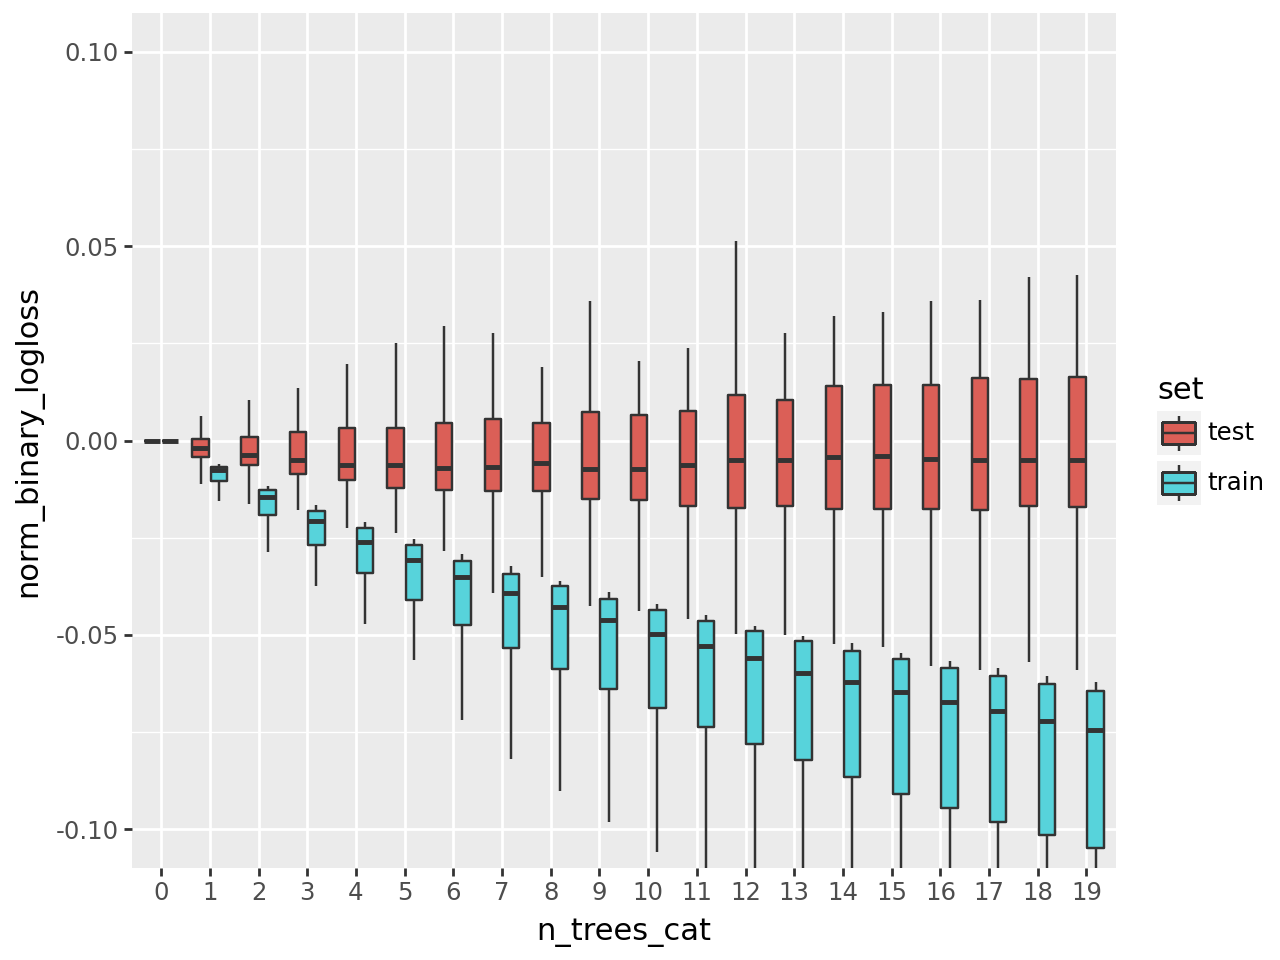

In [92]:
ggplot(data_lc[data_lc["n_trees"] < 20], aes(x="n_trees_cat", y="norm_binary_logloss", fill="set")) + geom_boxplot(outlier_alpha=0) + coord_cartesian(ylim=(-0.1, 0.1))

Let's compute feature importance now:

In [93]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": 'binary',
    "metric": 'binary_logloss',
    "learning_rate": 10e-3,
    "path_smooth": 0.2,
    "n_estimators": 20
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_across_periods(train_period_frequency=4, compute_importance=True)

2005-06-30T00:00:00.000000000
2006-06-30T00:00:00.000000000
2007-06-30T00:00:00.000000000
2008-06-30T00:00:00.000000000
2009-06-30T00:00:00.000000000
2010-06-30T00:00:00.000000000
2011-06-30T00:00:00.000000000
2012-06-30T00:00:00.000000000
2013-06-30T00:00:00.000000000
2014-06-30T00:00:00.000000000
2015-06-30T00:00:00.000000000
2016-06-30T00:00:00.000000000
2017-06-30T00:00:00.000000000
2018-06-30T00:00:00.000000000
2019-06-30T00:00:00.000000000
2020-06-30T00:00:00.000000000


({numpy.datetime64('2006-06-30T00:00:00.000000000'): {'training': OrderedDict([('binary_logloss',
                 [0.6764393313461329,
                  0.6743311680892395,
                  0.6722587622398003,
                  0.6701812566340893,
                  0.6680633330560638,
                  0.6661461193540082,
                  0.6641700959946609,
                  0.6623033469285969,
                  0.6603872077195351,
                  0.6585690737223735,
                  0.6565746127477914,
                  0.6546222626954848,
                  0.6527426078578252,
                  0.6508497231202065,
                  0.6490037073382126,
                  0.64709526823232,
                  0.64530430609054,
                  0.6434392042070479,
                  0.6416850062789065,
                  0.6399300518159549]),
                ('weighted-return',
                 [0.27591729266499027,
                  0.27591729266499027,
                  0.2759172926

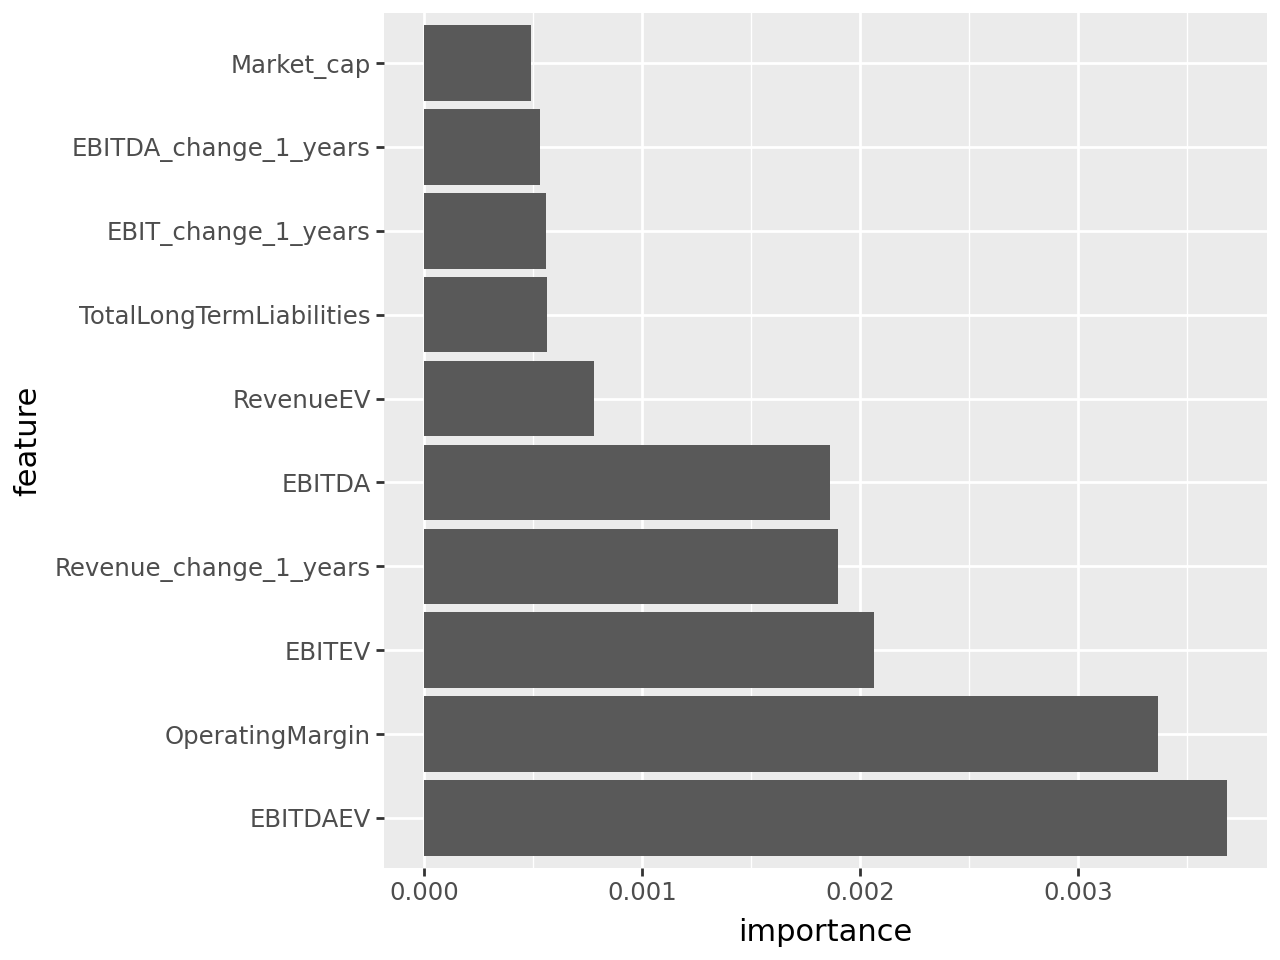

In [94]:
all_permutation_importances = all_permutation_importances.sort_values(["execution_date", "importance"], ascending=[False, False])

all_permutation_importances_sum = all_permutation_importances.groupby("feature")["importance"].mean().reset_index()

all_permutation_importances_sum = all_permutation_importances_sum.sort_values("importance", ascending=False)
all_permutation_importances_sum = all_permutation_importances_sum.head(10)

(
  ggplot(all_permutation_importances_sum) +
  geom_col(aes(x="feature", y="importance")) +
  coord_flip() +
  scale_x_discrete(limits=all_permutation_importances_sum["feature"].tolist())
)

This looks quite better because the most important features are related to the business metrics.

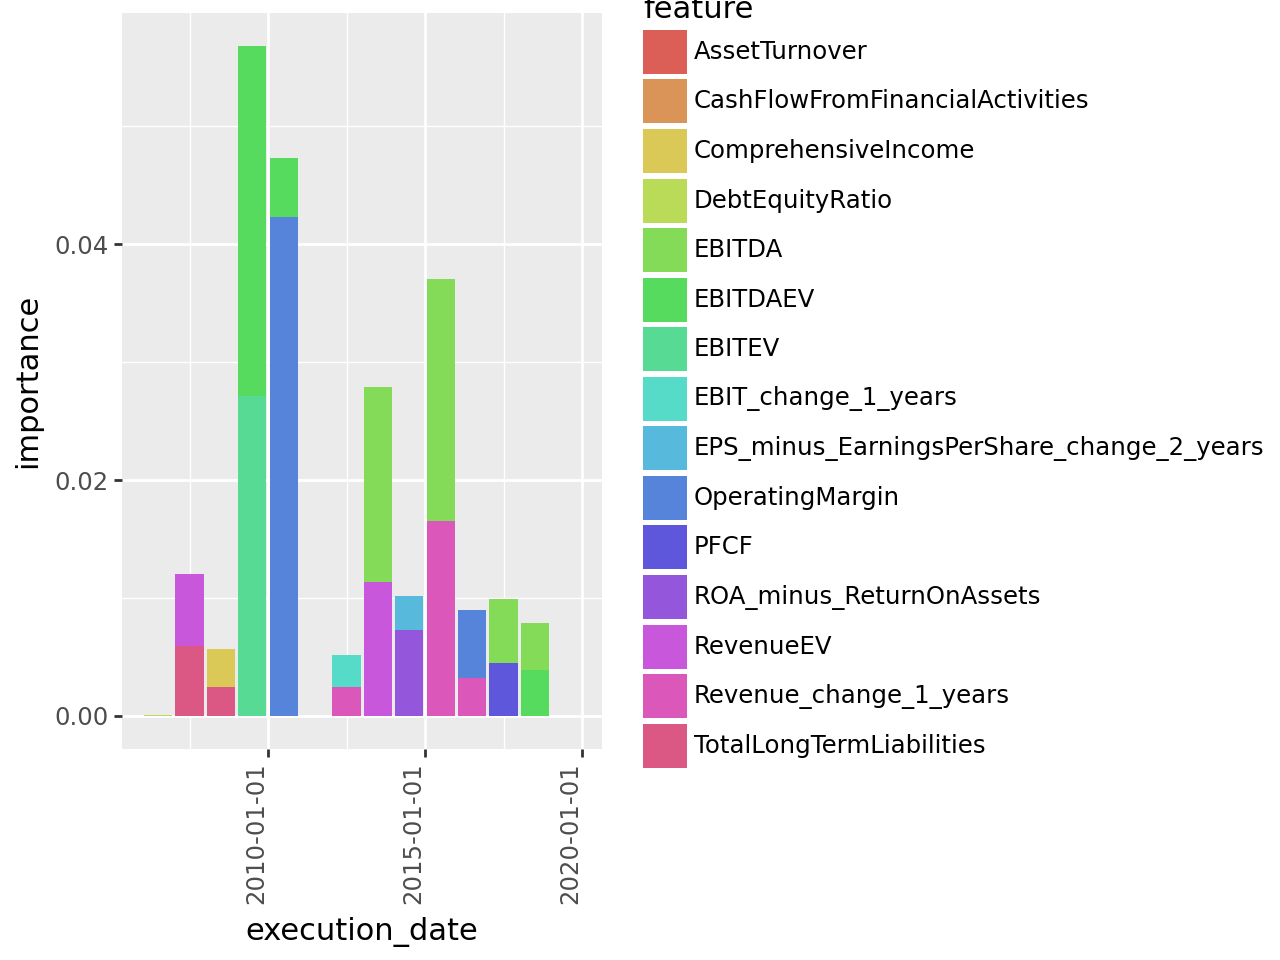

In [95]:
all_permutation_importances["rank"] = all_permutation_importances.groupby(['execution_date']).cumcount()

r_all_permutation_importances = all_permutation_importances[all_permutation_importances["rank"] < 2]

(
  ggplot(r_all_permutation_importances, aes(x="execution_date", y="importance", fill="feature")) +
  geom_col() +
  theme(axis_text_x=element_text(rotation=90, hjust=1))
)

Now we can plot the results in terms of `weighted-return`

In [96]:
def train_model_across_periods(train_period_frequency=1, compute_importance=False):
    global all_results
    global all_predicted_tickers_list
    global all_models
    global all_predicted_tickers

    for i, execution_date in enumerate(execution_dates):
        if i % train_period_frequency == 0:
            print(execution_date)
            all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(
                execution_date, all_results, all_predicted_tickers_list, all_models, compute_importance=compute_importance
            )

    all_predicted_tickers = pd.concat(all_predicted_tickers_list)
    return all_results, all_predicted_tickers, all_models

In [97]:
def train_model(train_set, test_set, compute_importance=False):
    global params
    global model
    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=top_wt_performance,
        callbacks=[lgb.record_evaluation(eval_result)]
    )

    return model, eval_result, X_train, X_test, pd.DataFrame()

In [98]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 10e-3,
    "path_smooth": 0.2,
    "n_estimators": 12
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

In [99]:
train_model_across_periods(train_period_frequency = 1, compute_importance = False)

test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [100]:
test_results_final_tree = test_results.sort_values(["execution_date", "n_trees"]).drop_duplicates("execution_date", keep="last")
train_results_final_tree = train_results.sort_values(["execution_date", "n_trees"]).drop_duplicates("execution_date", keep="last")

In [101]:
test_results_final_tree = merge_against_benchmark(test_results_final_tree, all_predicted_tickers)

And these are the results:

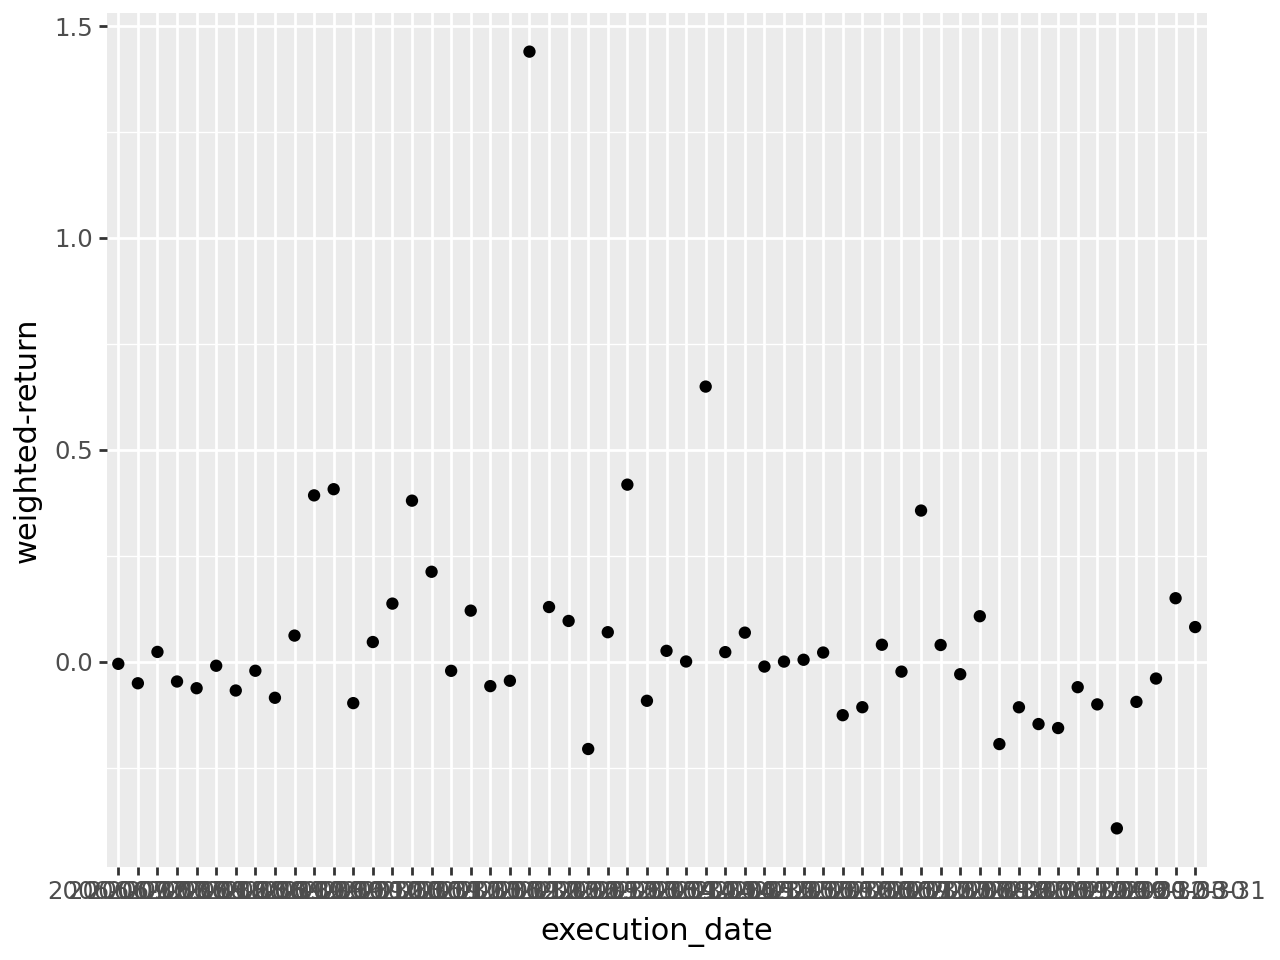

In [102]:
ggplot(
  test_results_final_tree[test_results_final_tree["weighted-return"] < 2],
  aes(x="execution_date")) + geom_point(aes(y="weighted-return")
)

N periods where we perform better than benchmark

In [103]:
len(test_results_final_tree[test_results_final_tree["weighted-return"] > test_results_final_tree["diff_ch_sp500_baseline"]]) / len(test_results_final_tree["weighted-return"])

0.4642857142857143

Median performance vs benchmark

In [104]:
test_results_final_tree["weighted-return"].mean()

0.054608803458771046

My model obtains a 5% more return than the sp500

In [105]:
test_results_final_tree["diff_ch_sp500_baseline"].mean()

0.022159133577893696

In [106]:
test_results_final_tree["weighted-return"].median()

-0.0020302561906538827

As it is negative, my model performs worse in more than half of the periods

In [107]:
test_results_final_tree["diff_ch_sp500_baseline"].median()

0.015525563344158869

However, the benchmark performs better in more than half of the periods

# **Assumptions**
- Our model is improving better because there are some periods/outliers in which the return is very high. As the median is negative (although it is close to 0), we have to invest a long period of time in order to beat the sp500.
- Other possibility is that there is a problem with data because of the difference between the media and median.

# **My comments**

We put the first one in 0, and then we add trees, showing the error of each period in the box.

We can see that the median error is decreasing, while some outliers decrease it a lot.

Box:

Represents the interquartile range (IQR), which contains the middle 50% of the data.

The line inside the box is the median, dividing the data into two equal parts.

Whiskers:

Extend from the box to show the range of data within 1.5 times the IQR.

Data points outside the whiskers are considered outliers.

Outliers:

Points outside the whiskers, indicating extreme or unusual values.

Median Position:

  - Closer to Q1: Data is skewed left (lower values are more frequent).

  - Closer to Q3: Data is skewed right (higher values are more frequent).

Box Size (IQR):

  - Larger box: Data is more spread out.

  - Smaller box: Data is more concentrated.

Whiskers:

  - Longer whiskers: Greater data dispersion.

  - Shorter whiskers: Data is more clustered.

Outliers:

  - Many outliers may indicate anomalies or errors in the data